In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import axes3d

import scipy
from scipy.optimize import curve_fit
import re


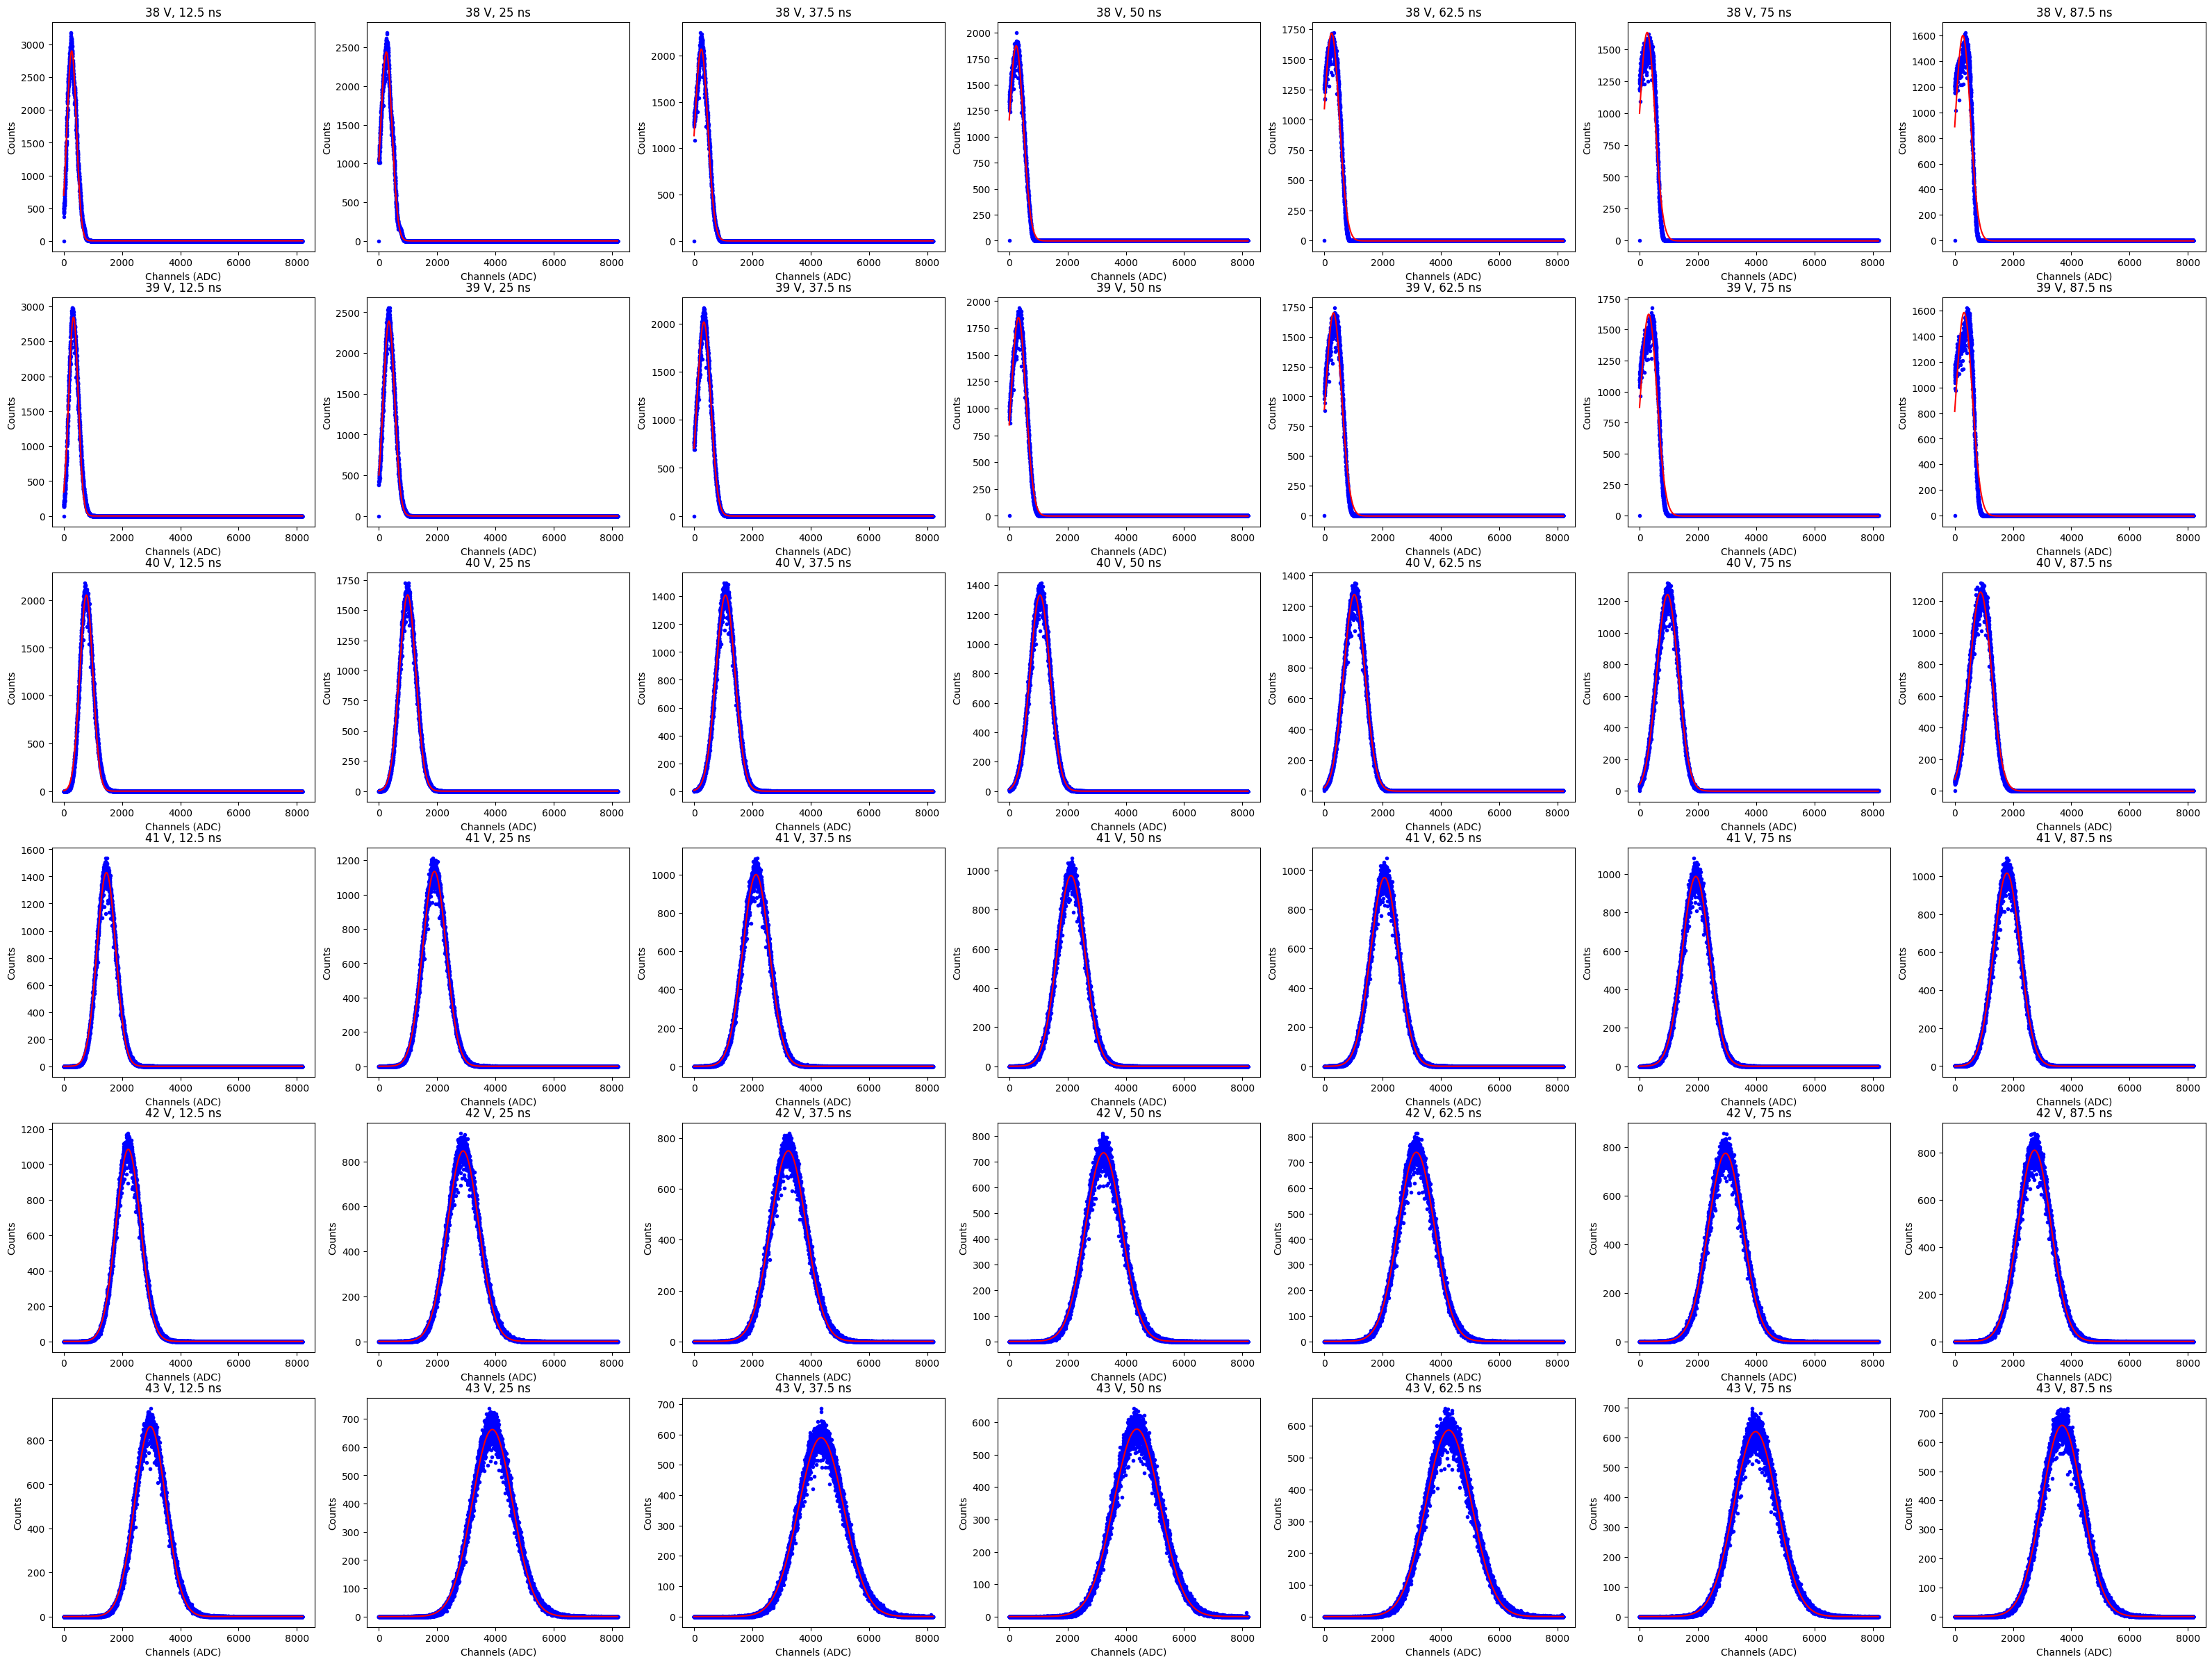

In [2]:
#Define the Gaussian function
def Gauss(x, *p):
    H, A, x0, sigma = p
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
    
signal_mean = []

plt.figure(figsize = (40,30))
for i in range(1,43):
    ax = plt.subplot(6,7,i) #title = run_volt #+ run_st #)
    file_name = './Preliminary_runs/LED_runs/Run' + str(i) + '_PHA_HG_0_0.txt'
    data = np.loadtxt(file_name)
    ax.plot(np.arange(len(data)),data,'b.')
    ax.set_xlabel("Channels (ADC)")
    ax.set_ylabel("Counts")
    config = str('./Preliminary_runs/LED_runs/Run' + str(i) + '_Info.txt')
    file1 = open(config,'r')
    temp_list = file1.readlines()
    run_volt = (str(temp_list[39])[30:45]).strip()
    run_st = (str(temp_list[119])[30:45]).strip()
    plt.gca().set_title(run_volt + ", " + run_st)
    
    p0 = [0,np.amax(data),np.argmax(data),100]
    parameters, covariance = curve_fit(Gauss, np.arange(len(data)) , data, p0)
    H = parameters[0]
    A = parameters[1]
    x0 = parameters[2]
    sigma = parameters[3]
    fit = Gauss(np.arange(len(data)),H,A,x0,sigma)
    
    signal_mean.append([(run_volt + ", " + run_st),x0])
    ax.plot(np.arange(len(data)),fit,'r-')
    
plt.show()

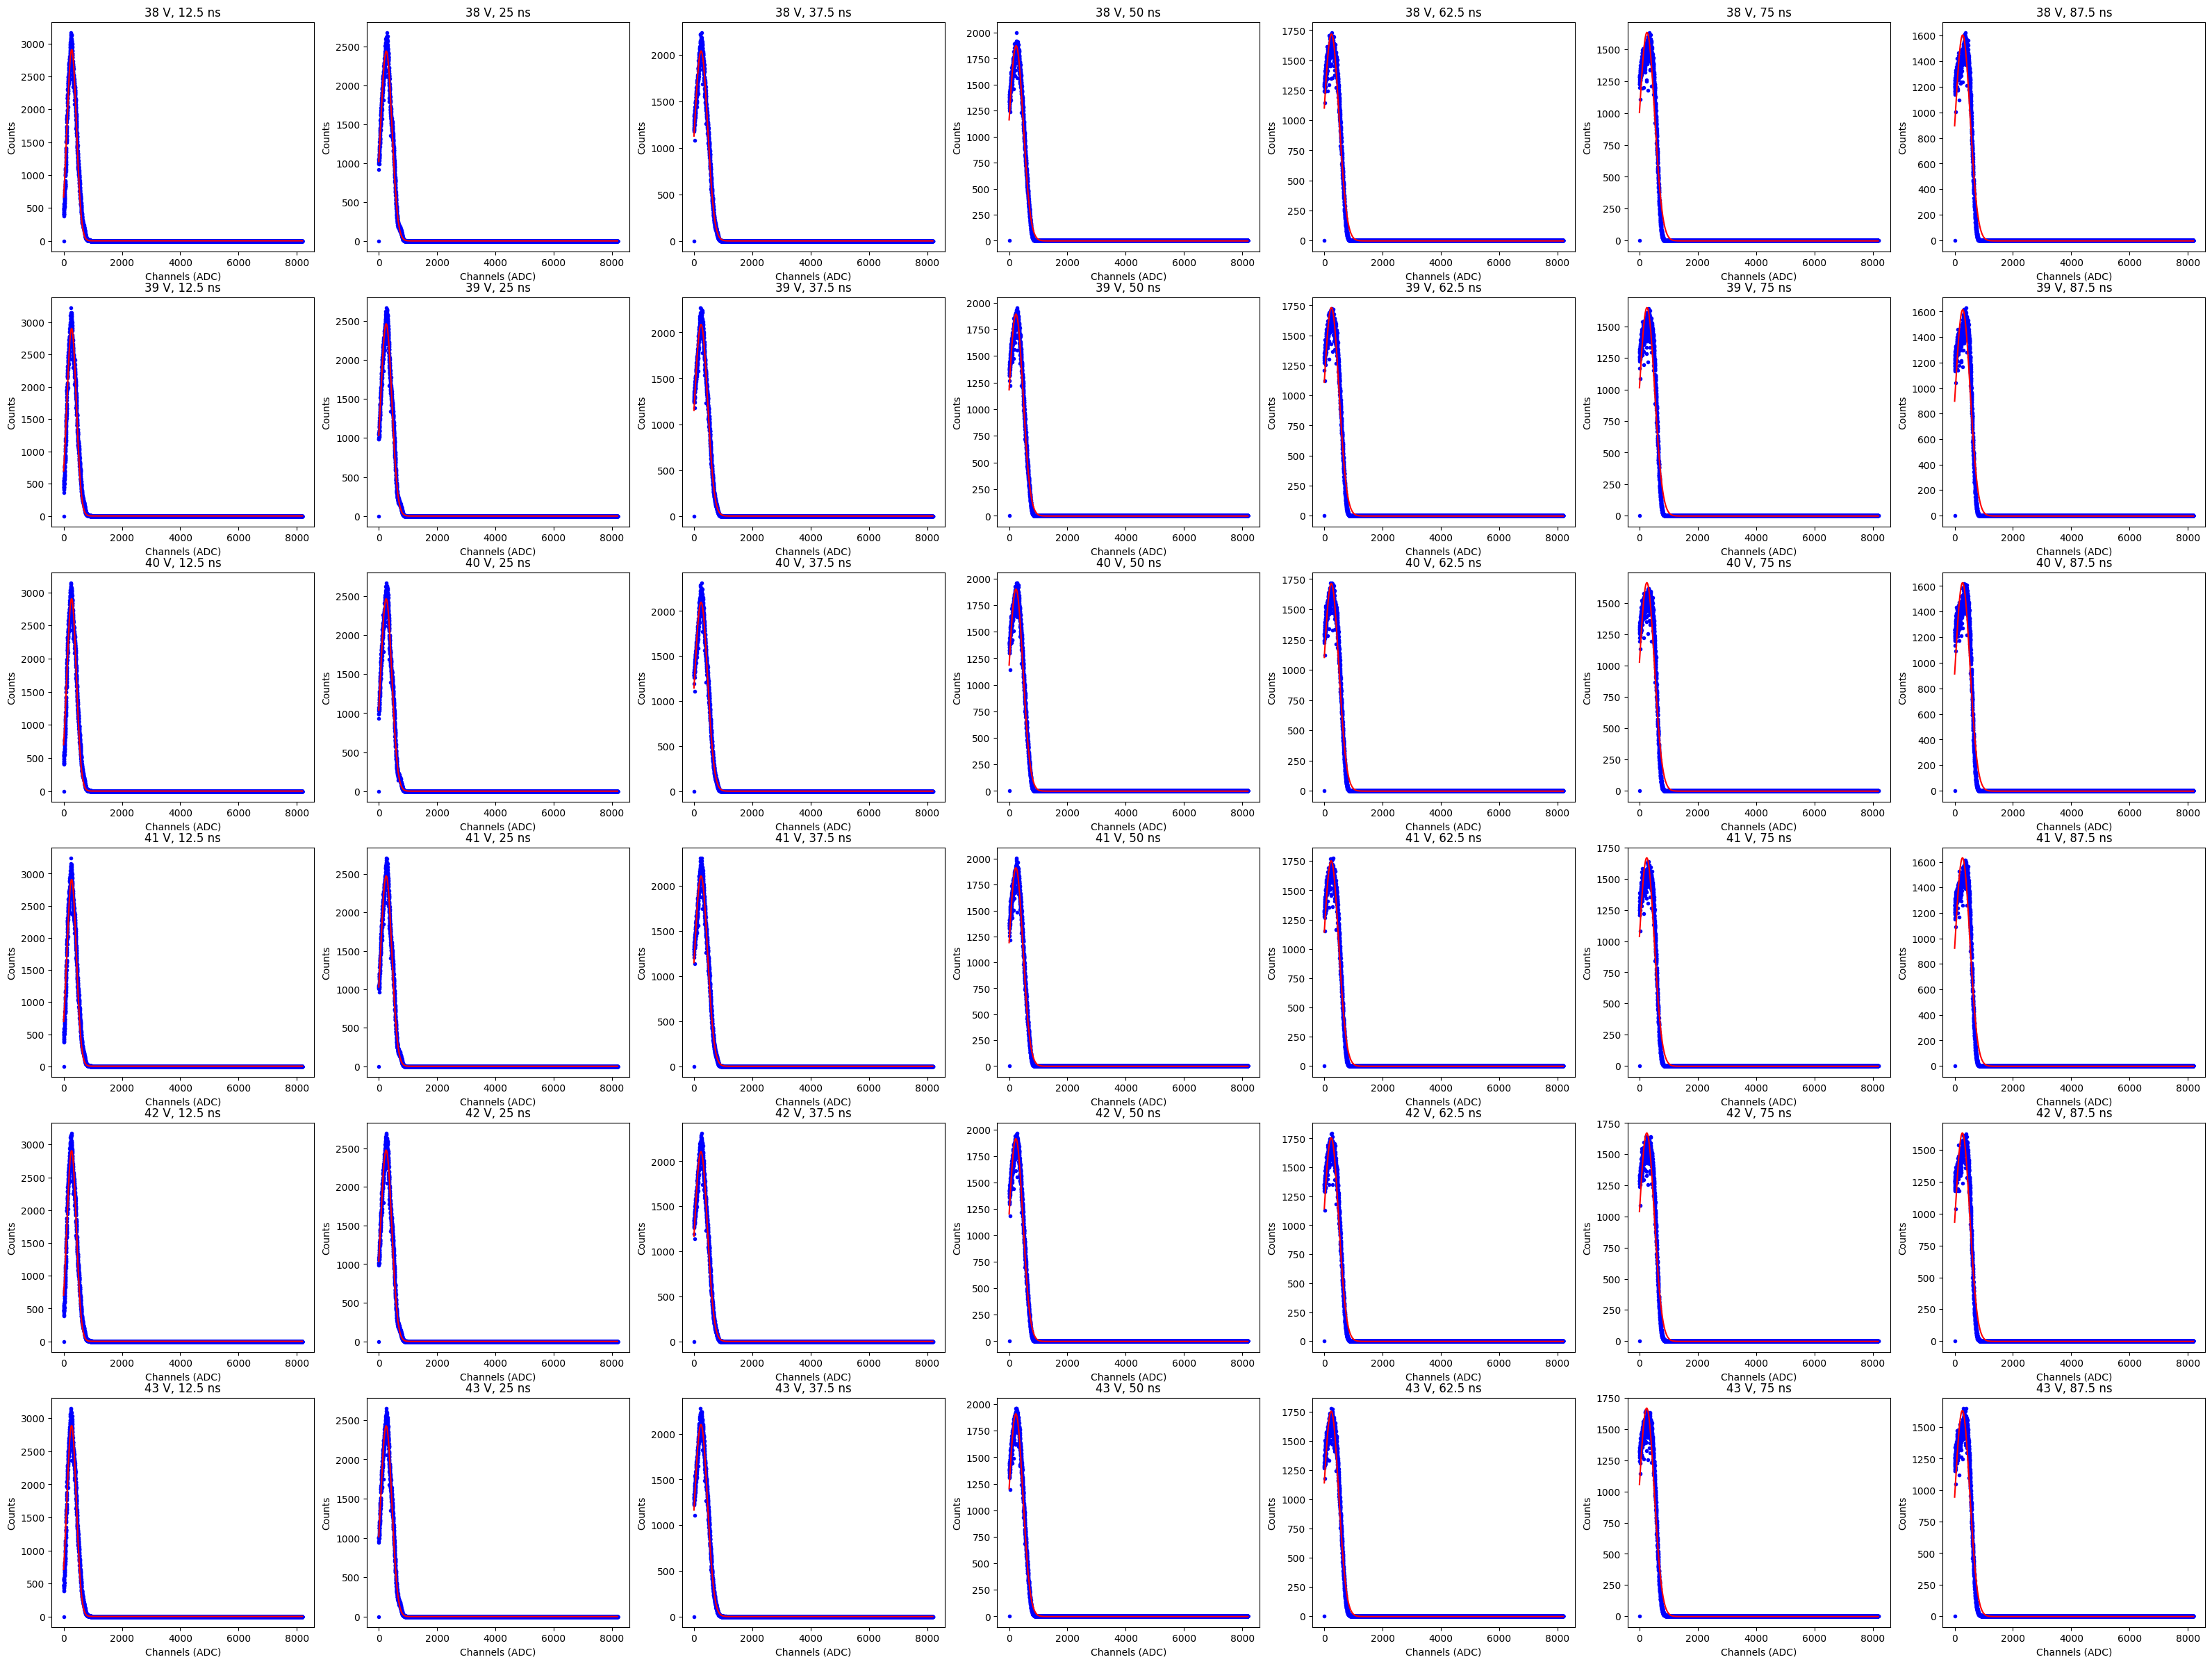

In [3]:
plt.figure(figsize = (40,30))

pedestal_std = []

for i in range(1,43):
    ax = plt.subplot(6,7,i)
    file_name = './Preliminary_runs/Pedestal_runs/Run' + str(i) + '_PHA_HG_0_0.txt'
    data = np.loadtxt(file_name)
    ax.plot(np.arange(len(data)),data,'b.')
    ax.set_xlabel("Channels (ADC)")
    ax.set_ylabel("Counts")
    config = str('./Preliminary_runs/Pedestal_runs/Run' + str(i) + '_Info.txt')
    file1 = open(config,'r')
    temp_list = file1.readlines()
    run_volt = (str(temp_list[39])[30:45]).strip()
    run_st = (str(temp_list[119])[30:45]).strip()
    plt.gca().set_title(run_volt + ", " + run_st)
    
    p0 = [0,np.amax(data),np.argmax(data),100]
    parameters, covariance = curve_fit(Gauss, np.arange(len(data)) , data, p0)
    H = parameters[0]
    A = parameters[1]
    x0 = parameters[2]
    sigma = parameters[3]
    fit = Gauss(np.arange(len(data)),H,A,x0,sigma)
    pedestal_std.append([(run_volt + ", " + run_st),sigma])
    ax.plot(np.arange(len(data)),fit,'r-')
    
plt.show()

In [4]:
final_data = np.empty(shape=[0,3])
for i in range(0,len(signal_mean)):
    for j in range(0,len(pedestal_std)):
        if signal_mean[i][0] in pedestal_std[j][0]:
            sweep_info = signal_mean[i][0].split(",")
            bias_v = float(re.search("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", str(sweep_info[0])).group())
            shape_t = float(re.search("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", str(sweep_info[1])).group())
            resolution = signal_mean[i][1]/pedestal_std[j][1]
            final_data = np.append(final_data,[[bias_v,shape_t,resolution]],axis=0)

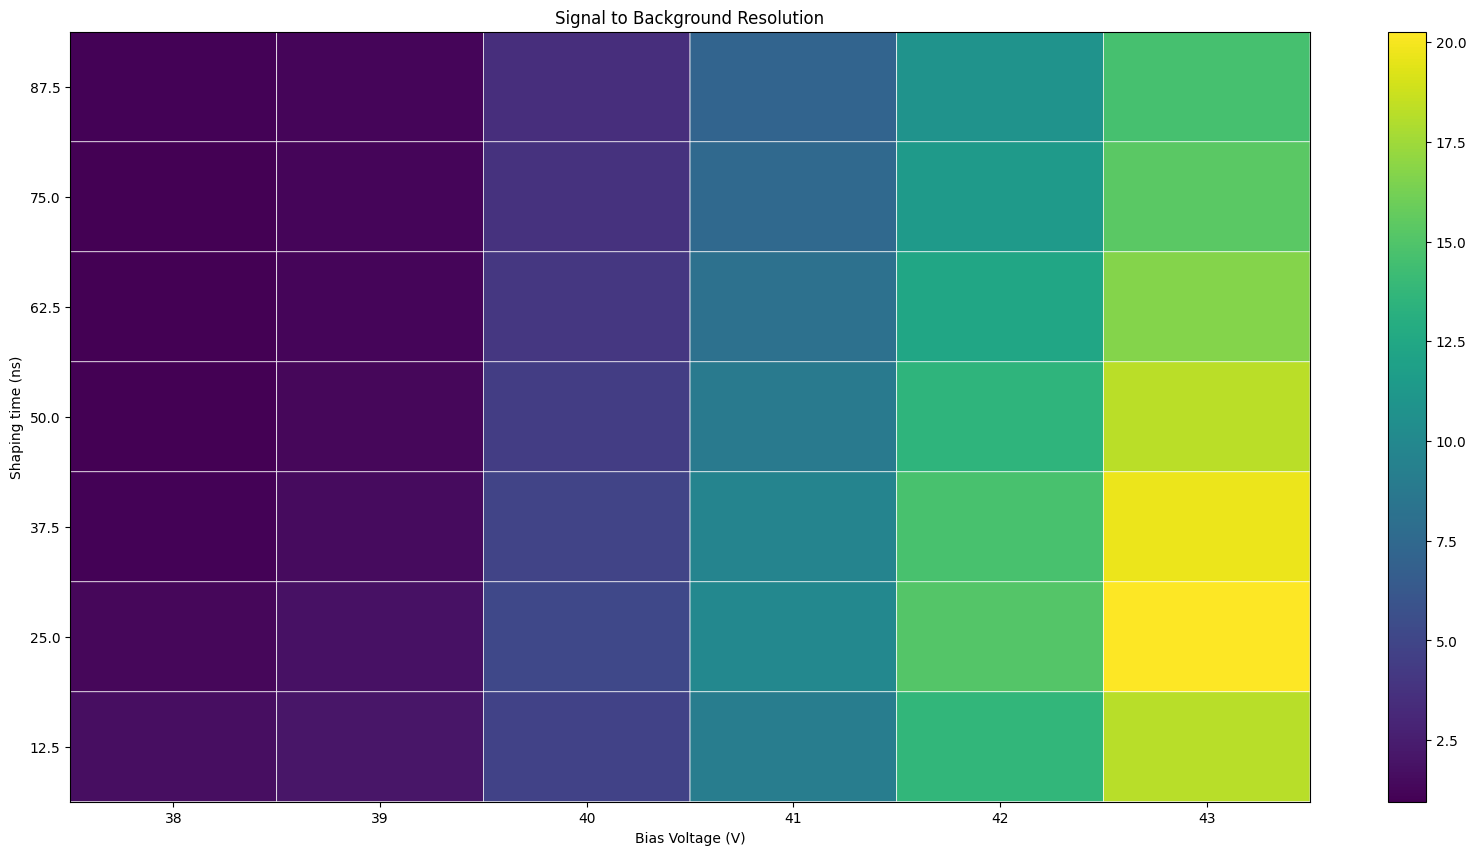

In [5]:
fig = plt.figure(figsize = (20,10))
bias_v = final_data[:,0]
shape_t = final_data[:,1]
resolution = final_data[:,2]
bias_v = np.unique(bias_v)
shape_t = np.unique(shape_t)
res = resolution.reshape(len(bias_v),len(shape_t))
ax = fig.add_subplot(111)

cax = ax.pcolor(bias_v, shape_t, np.transpose(res), vmin=np.min(res), edgecolors='w', linewidths=0.5, vmax=np.max(res),cmap='viridis')
fig.colorbar(cax)

ax.set_xticks(bias_v)
ax.set_yticks(shape_t)
ax.set_title('Signal to Background Resolution')
ax.set_xlabel('Bias Voltage (V)')
ax.set_ylabel('Shaping time (ns)')

plt.show()
